In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#plot_n_b_psth.ipynb
#plot neural and behavior psth

import scipy.io as sio
import scipy.stats as sio_stat
import scipy.interpolate
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 
import matplotlib.colors as colors

import os
import pickle
import sys
import copy

import time
import pylab as pl
from IPython import display

from bmi_dynamics_code import behavior_co_obs as bmi_b
from bmi_dynamics_code import data_for_v as preeyacode
from bmi_dynamics_code import util as bmi_util

import timeit
from sklearn import decomposition as skl_decomp

%matplotlib notebook

In [3]:
%matplotlib notebook

In [32]:
#LOAD AND UNPACK DATA: 

# data_dir = '/Users/vivekathalye/Dropbox/Code/preeya_co_obstacle'
save_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\command_temporal_order'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
ext_list = ['.png', '.eps']

home_dir = r'D:\Dropbox\Code\preeya_co_obstacle'
data_dir = r'D:\Dropbox\Data\preeya_co_obstacle'
data_path = os.path.join(data_dir, 'for_v_df.pkl')
print(os.path.exists(data_path))
d = pickle.load(open(data_path))

#UNPACK: 
decoder = d['decoder']
pre = d['pre']
num_targets = d['num_targets']
sample_period = d['sample_period']
target_hold_time = d['target_hold_time']
num_neurons = d['num_neurons']
target_color = d['target_color']
obs_big = d['obs_big']
obs_small = d['obs_small']
target_r_task = d['target_r_task'] #target_r_task = {0:1.7, 1:2.0}
cursor_r = d['cursor_r']
target_r_eff = d['target_r_eff']
target_pos = d['target_pos']
target_angle = np.arctan2(target_pos[:,1], target_pos[:,0])
target_dist = np.linalg.norm(target_pos, axis=1)
obs_pos = d['obs_pos']

tc_meta = d['tc_meta']
task_list = d['task_list']
num_tasks = len(task_list)
task2idx = d['task2idx']
idx2task = bmi_util.invert_dic(task2idx)
task2tc = d['task2tc']
tc_list = d['tc_list']
df = d['df']
df_label = d['df_label']

task_color = ['k', 'r']

True


### Analysis Description
compare
(true mean)-(movement_pool mean)
vs
(shuffle mean)-(movement_pool mean)
shuffle: 
shuffle the movement label of each trial.  then draw trials at random.  
(this analysis depends on first identifying valid movements for the command.)

for each command-movement:
is it sig different than the command-movement_pool mean?
report fraction OR number of command-movements that are sig different for each session.  

### To Do
-movement: target, task. 
option 1: augment task to include cw or ccw": 0=c0
option 2: add a third dimension of cw or ccw

-run for [-5,5] and [-1,1]
-also run Fig 3H for [-5,5] and [-1,1]

In [33]:
save_dir

'D:\\Dropbox\\BMI_co_obs_paper\\data\\vivek\\command_temporal_order'

In [5]:
#Pre-processing: 

bmi_b.preprocess_bmi_df(df, target_pos, pre, num_tasks, num_targets)
num_cw = 2
cw_label = ['cw', 'ccw']
task_rot_list = [0,1.1,1.2]

#Binning: 
#MAGNITUDE:
num_mag_bins = 5
num_mag_bins_analyze = 4
# mag_bin_perc = np.array([0,25,50,75,100])
mag_bin_perc = np.concatenate([np.linspace(0,95,5),np.array([100])])
#ANGLE:
num_angle_bins = 8
T0_angle = -3*(2*np.pi)/8
mag_bin, mag_bin_edges, mag_bin_c, angle_bin_c, angle_bin, angle_bin_edges =\
bmi_b.def_command_bin(df, mag_bin_perc, num_angle_bins, T0_angle)
#CENTER ANGLE DATA FOR BINNING (based on bin boundaries): 
angle_center_for_binning = bmi_b.df_center_angle_for_binning(df, angle_bin)
#BIN: 
bmi_b.df_bin_command(df, mag_bin_edges,angle_bin_edges)

#Pre-processing continued:

#Center angles to command bin, target: 
bmi_b.center_df_angle(df, angle_bin_c, target_angle)

('angle_center:', 22.5)
('min centered angle:', -157.4975492637699)
('max centered angle:', 202.46708261619673)


In [6]:
df.head()

,n_0,n_1,n_2,n_3,n_4,n_5,n_6,n_7,n_8,n_9,...,cw,target_axis_signed_area,target_axis_area,u_v_mag_bin,u_v_angle_bin,p_angle_ctr_t,v_angle_ctr_t,u_p_angle_ctr_t,u_v_angle_ctr_t,u_v_angle_ctr_bin
0,2.0,1.0,0.0,0.0,1.0,4.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,5.0,0.733399,-5.024228,-4.379982,-4.379982,1.903203
1,2.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,3.0,5.0,0.751804,-5.020172,-4.939422,-4.939422,1.343763
2,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,2.0,4.0,0.766647,-5.167754,-5.175365,-5.175365,1.107820
3,5.0,0.0,0.0,1.0,0.0,4.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.765679,0.425349,-1.608672,-1.608672,-1.608672
4,4.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,5.0,0.766238,-5.440931,-5.080391,-5.080391,1.202795


In [7]:
list(df.columns)

['n_0',
 'n_1',
 'n_2',
 'n_3',
 'n_4',
 'n_5',
 'n_6',
 'n_7',
 'n_8',
 'n_9',
 'n_10',
 'n_11',
 'n_12',
 'n_13',
 'n_14',
 'n_15',
 'n_16',
 'n_17',
 'n_18',
 'n_19',
 'n_20',
 'n_21',
 'n_22',
 'n_23',
 'n_24',
 'n_25',
 'n_26',
 'n_27',
 'n_28',
 'n_29',
 'n_30',
 'n_31',
 'n_32',
 'n_33',
 'n_34',
 'n_35',
 'n_36',
 'n_37',
 'n_38',
 'n_39',
 'n_40',
 'n_41',
 'n_42',
 'n_43',
 'u_px',
 'u_py',
 'u_vx',
 'u_vy',
 'kin_px',
 'kin_py',
 'kin_vx',
 'kin_vy',
 'task',
 'tc',
 'target',
 'trial',
 'bin',
 'trial_start',
 'trial_stop',
 'target_size',
 'obs_size',
 'bin_end',
 'prog',
 'trial_cond',
 'p_mag',
 'p_angle',
 'v_mag',
 'v_angle',
 'u_p_mag',
 'u_p_angle',
 'u_v_mag',
 'u_v_angle',
 'd2target',
 'x_error',
 'y_error',
 'task_rot',
 'cw',
 'target_axis_signed_area',
 'target_axis_area',
 'u_v_mag_bin',
 'u_v_angle_bin',
 'p_angle_ctr_t',
 'v_angle_ctr_t',
 'u_p_angle_ctr_t',
 'u_v_angle_ctr_t',
 'u_v_angle_ctr_bin']

<IPython.core.display.Javascript object>


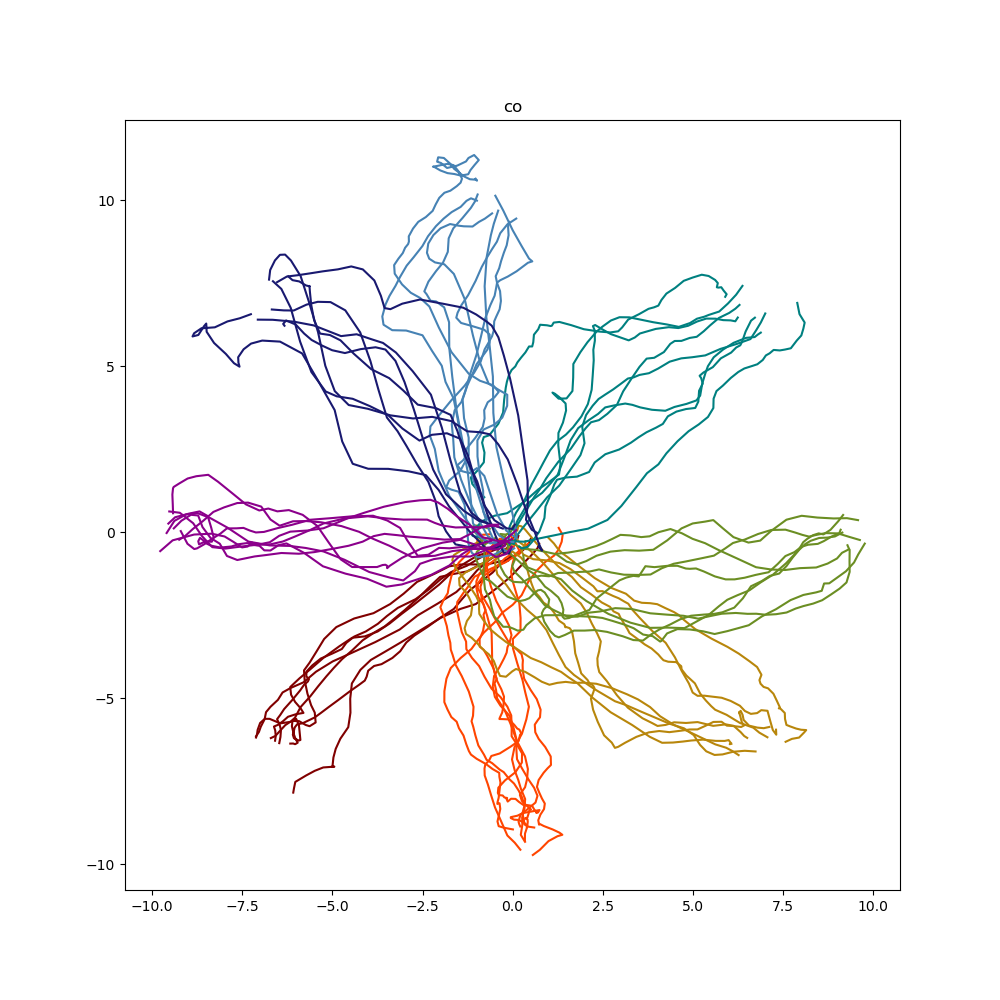

<IPython.core.display.Javascript object>


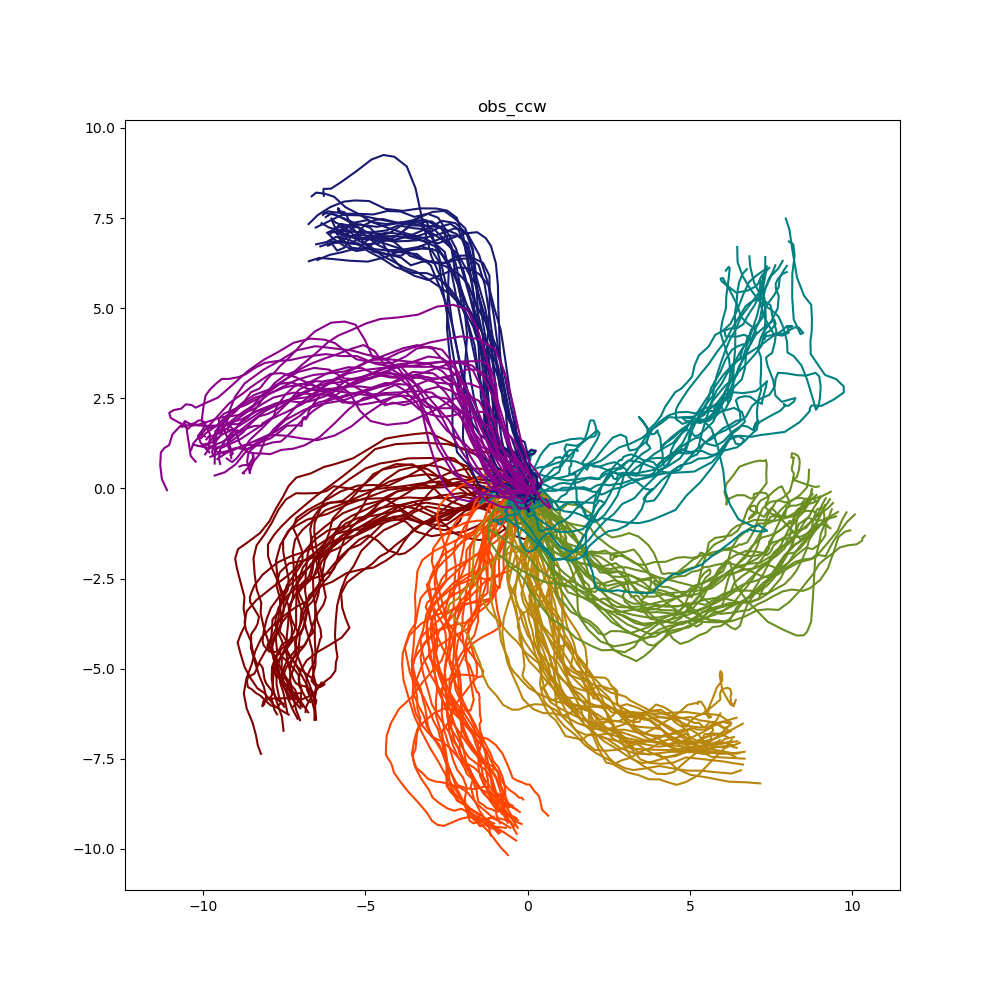

<IPython.core.display.Javascript object>


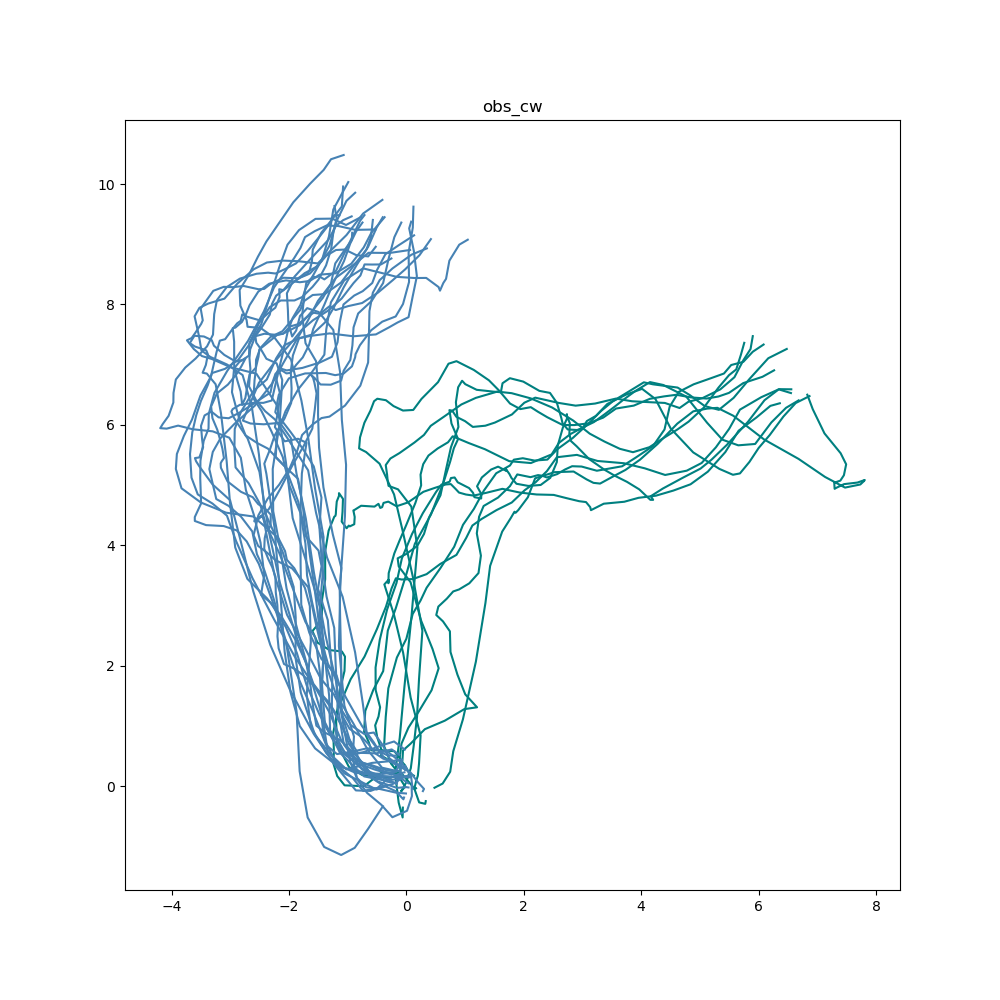

In [7]:
#Plot cw vs ccw trials, to confirm: 
plot = {}
plot['size'] = (10,10)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)
task_rot_list = [0,1.1,1.2]
task_rot_label = ['co','obs_ccw', 'obs_cw']

for i,task in enumerate(task_rot_list):
    plt.figure(figsize=plot['size'])
    plt.title(task_rot_label[i])
    for target in range(num_targets):    
            sel = (df['task_rot']==task) & (df['bin']>=0) & (df['target']==target)
            df_sel = df[sel]
            #------------------------------------------------------------------------------------
            #TRIALS: 
            trial_start = np.where(df_sel['bin']==0)[0]
            trial_stop = np.where(df_sel['bin_end']==0)[0]
            trial_bound = np.vstack((trial_start,trial_stop)).T
            #------------------------------------------------------------------------------------
            for bnd in trial_bound[:,:]: #trial_bound[0:1,:]:
    #             if (task_str == 'co') or (task_str == 'obs') and (df_sel['obs_size'][bnd[0]:bnd[0]+1] == obs_big).bool(): 
                x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
                y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
                color = target_color[target]
                plt.plot(x,y,'-',color=color)

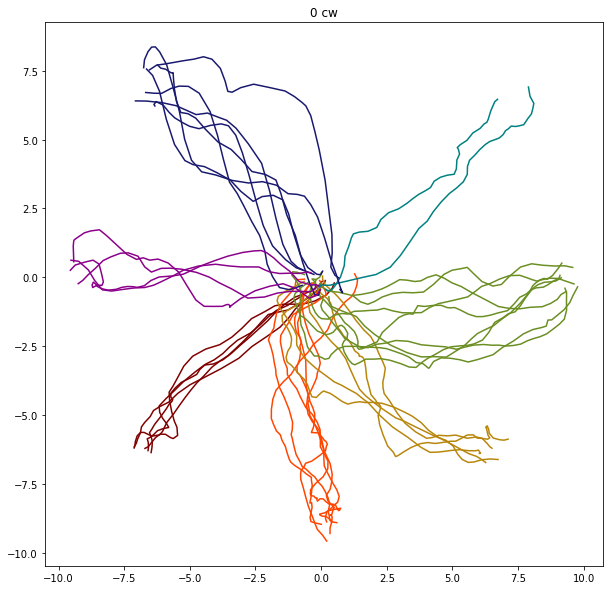

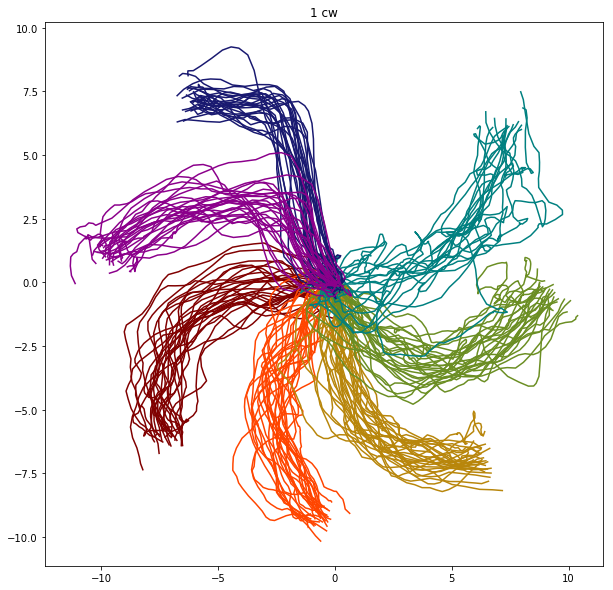

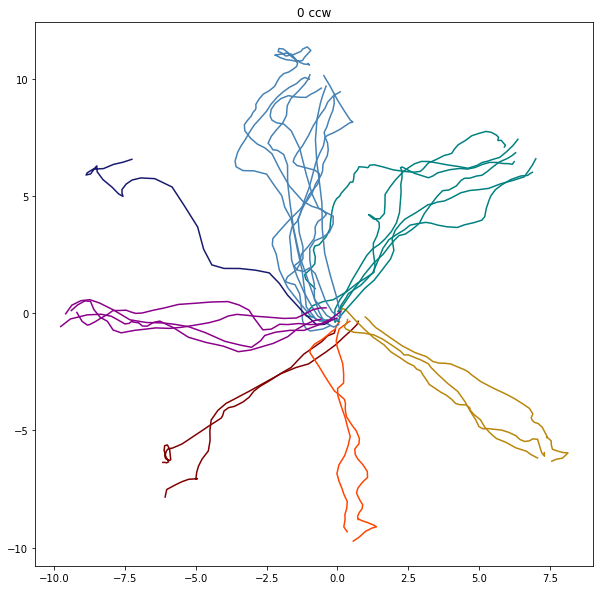

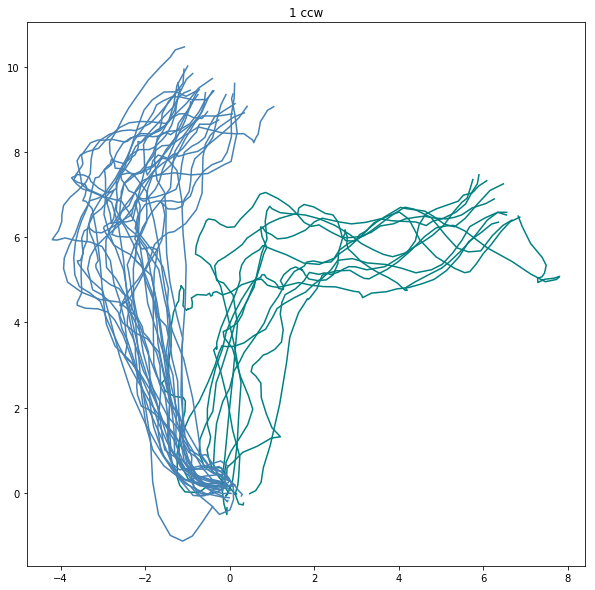

In [51]:
#Older plot code which has 'cw' as a separate variable:
# #Plot cw vs ccw trials, to confirm: 
# plot = {}
# plot['size'] = (10,10)
# plot['xlim'] = (-12.5,12.5)
# plot['ylim'] = (-12.5,12.5)

# for cw in [0,1]:
#     for task_str in task_list: 
#         task = task2idx[task_str]
#         plt.figure(figsize=plot['size'])
#         plt.title(str(task) + ' ' + cw_label[cw])
#         for target in range(num_targets):    
#                 sel = (df['task']==task) & (df['bin']>=0) & (df['target']==target) & (df['cw'] == cw)
#                 df_sel = df[sel]
#                 #------------------------------------------------------------------------------------
#                 #TRIALS: 
#                 trial_start = np.where(df_sel['bin']==0)[0]
#                 trial_stop = np.where(df_sel['bin_end']==0)[0]
#                 trial_bound = np.vstack((trial_start,trial_stop)).T
#                 #------------------------------------------------------------------------------------
#                 for bnd in trial_bound[:,:]: #trial_bound[0:1,:]:
#         #             if (task_str == 'co') or (task_str == 'obs') and (df_sel['obs_size'][bnd[0]:bnd[0]+1] == obs_big).bool(): 
#                     x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
#                     y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
#                     color = target_color[target]
#                     plt.plot(x,y,'-',color=color)

In [6]:
num_mag_bins_analyze=4
def plot_command_bin(): 
    bmi_b.plot_polar_bins(angle_bin_edges, mag_bin_edges[:,:(num_mag_bins_analyze)], target_color)

<IPython.core.display.Javascript object>


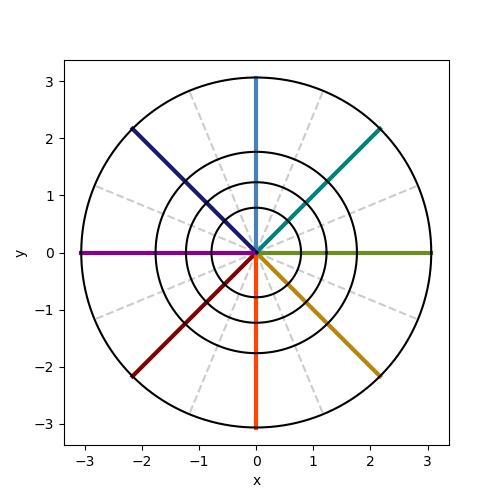

In [7]:
plt.figure(figsize=(5,5))
plot_command_bin()

### Define movement list, and identify movements which have enough observations of each command

In [14]:
#Useful especially when splitting an obstacle movement into cw vs ccw.
move_list = []
for target in range(num_targets):
    for task in task_rot_list:
        move_list.append((target,task))
        
#List of commands in case it's useful    
c_list = []
for bm in range(num_mag_bins_analyze):
    for ba in range(num_angle_bins):
        c_list.append((bm,ba))        

# Other attempts at defining the movement list
# move_list = []
# for target in range(num_targets):
#     for task in range(num_tasks):
#         if task == 0:
#             move_dic = {}
#             move_dic['target'] = target
#             move_dic['task'] = task
#             move_list.append(move_dic)
#         elif task==1:
#             for cw in range(num_cw):
#                 move_dic = {}
#                 move_dic['target'] = target
#                 move_dic['task'] = task
#                 move_dic['cw'] = cw
#                 move_list.append(move_dic)

# move_list = []
# for target in range(num_targets):
#     for task in range(num_tasks):
#         if task == 0:
#             move_list.append((target,task))
#         elif task==1:
#             for cw in range(num_cw):
#                 move_list.append((target,task,cw))

In [9]:
move_list

[(0, 0),
 (0, 1.1),
 (0, 1.2),
 (1, 0),
 (1, 1.1),
 (1, 1.2),
 (2, 0),
 (2, 1.1),
 (2, 1.2),
 (3, 0),
 (3, 1.1),
 (3, 1.2),
 (4, 0),
 (4, 1.1),
 (4, 1.2),
 (5, 0),
 (5, 1.1),
 (5, 1.2),
 (6, 0),
 (6, 1.1),
 (6, 1.2),
 (7, 0),
 (7, 1.1),
 (7, 1.2)]

In [10]:
#Identify movements + num_obs +sel for each command
#also save for each movement separately

bin_buffer = 5 #only count data after the first 5 samples and before the last 5 samples: 
min_obs = 15
cm_dic = {}
#Loop over command:
for bm in range(num_mag_bins_analyze):
    for ba in range(num_angle_bins):
        c = (bm,ba)
        cm_dic[c] = []
        cm_dic[c,'num_obs'] = []
        #Loop over movement: 
        for m in move_list:
            sel = \
            (df['target']==m[0]) \
            & (df['task_rot']==m[1]) \
            & (df['bin'] >= bin_buffer) \
            & (df['bin_end'] >= bin_buffer) \
            & (df['u_v_mag_bin'] == bm) \
            & (df['u_v_angle_bin'] == ba)
            num_obs = sum(sel)
#             print(bm, ba, m, num_obs)
            #ASSIGN:
            cm_dic[c,m,'sel'] = sel
            cm_dic[c,m,'num_obs'] = num_obs
            if num_obs >= min_obs:
                cm_dic[c].append(m)
                cm_dic[c,'num_obs'].append(num_obs)
#Make the movement-pool sel: 
for bm in range(num_mag_bins_analyze):
    for ba in range(num_angle_bins):
        c = (bm,ba)
        cm_dic[c, 'sel'] = np.zeros(df.shape[0]).astype('bool')
        for m in cm_dic[bm,ba]:
            cm_dic[c, 'sel'] = cm_dic[c, 'sel'] \
            | cm_dic[c,m,'sel']

In [ ]:
#Plot the distribution over number of movements each command has: 

In [17]:
num_m_list = []
for c in c_list:
    num_m_list.append(len(cm_dic[c]))
num_m = np.array(num_m_list)
print(num_m_list)


[5, 5, 7, 5, 5, 5, 3, 2, 6, 6, 8, 9, 7, 4, 3, 3, 6, 5, 6, 7, 7, 5, 3, 6, 6, 5, 4, 3, 7, 8, 6, 6]


In [27]:
bin_c

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [36]:
save_dir

'D:\\Dropbox\\BMI_co_obs_paper\\data\\vivek\\command_temporal_order'

<IPython.core.display.Javascript object>


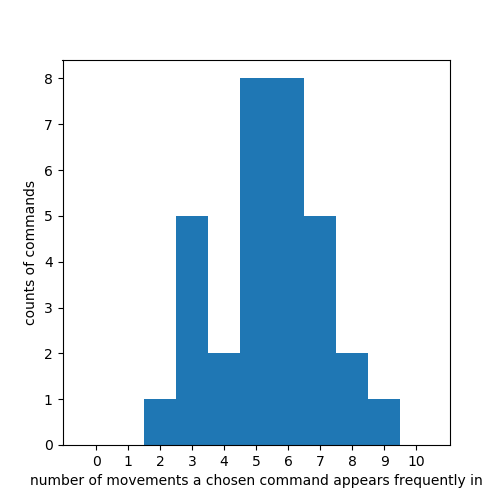

In [35]:
save_bool = True
fig_name = 'hist_num_move_for_command'


bin_e = np.arange(0,12)-0.5
bin_c = np.convolve(bin_e, np.array([0.5, 0.5]), 'valid')
plt.figure(figsize=(5,5))
plt.hist(num_m, bins=bin_e)
plt.xticks(bin_c)
plt.xlabel('number of movements a chosen command appears frequently in')
plt.ylabel('counts of commands')

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)

### Inspect the command-movement data structure:

In [14]:
print(cm_dic[(0,0),'num_obs'])
print(sum(cm_dic[(0,0),'num_obs']))

[22, 33, 28, 28, 35]
146


In [15]:
np.where(cm_dic[(0,0), 'sel'])[0]

array([ 3016,  3254,  3394,  3480,  3523,  3527,  3596,  3669,  3683,
        3715,  3727,  3891,  3945,  3974,  4022,  4030,  4087,  4090,
        4109,  4176,  4251,  4276,  4302,  4387,  4436,  4452,  4465,
        4492,  4499,  4504,  4537,  4637,  4679,  4766,  4871,  4901,
        4908,  4971,  4972,  4981,  5117,  5207,  5209,  5254,  5261,
        5317,  5375,  5412,  5665,  5692,  5697,  5699,  5738,  5755,
        5780,  6442,  6456,  6483,  6552,  8350,  8402,  8536,  8538,
        8685,  8696,  8743,  8752,  8796,  8806,  8855,  8904,  8955,
        8956,  8998,  9009,  9183,  9204,  9254,  9441,  9466,  9511,
        9534,  9571,  9579,  9582,  9616,  9618,  9620,  9640,  9669,
        9684,  9689,  9692,  9714,  9720,  9837,  9951,  9958, 10100,
       10186, 10240, 10325, 10414, 10425, 10458, 10720, 10724, 10853,
       11006, 11200, 11209, 11211, 11340, 11382, 11555, 11630, 11654,
       11677, 11696, 11776, 11801, 11802, 11839, 11941, 11947, 11979,
       12033, 12083,

In [136]:
cm_dic[(0,0)]

[(0, 1.1), (1, 1.1), (2, 1.1), (3, 1.1), (4, 1.1)]

In [137]:
np.where(cm_dic[(0,0),(0,1.1),'sel'])[0]

array([3016, 3254, 3394, 3480, 3523, 3527, 8350, 8402, 8536, 8538, 8685,
       8696, 8743, 8752, 8796, 8806, 8855, 8904, 8955, 8956, 8998, 9009],
      dtype=int64)

In [138]:
#mag_bin, angle_bin
cm_dic[3,4]

[(3, 0), (3, 1.1), (4, 0), (4, 1.1), (4, 1.2), (5, 0), (5, 1.2)]

In [140]:
cm_dic[(3,4),'num_obs']

[23, 76, 25, 59, 33, 15, 28]

### Shuffle movement label of each trial, to serve as a control

In [277]:
#make a shuffle mat for each command.
#shuffle mat contains the idxs chosen for each shuffle 
#For each movement, pick K samples at random from the 'movement-pooled'
num_shuffle = 1000
#loop command
#loop movement
#def shuffle_mat
for bm in range(num_mag_bins_analyze):
    for ba in range(num_angle_bins):
        c = (bm,ba)
        c_idxs = np.where(cm_dic[c,'sel'])[0]
#         print(c_idxs)
        #loop the movements: 
        for m in cm_dic[c]:
            num_obs = cm_dic[c,m,'num_obs']
            shuffle_mat = np.ones((num_obs, num_shuffle))*np.nan
            for s in range(num_shuffle):
                shuffle_mat[:,s] = np.random.choice(c_idxs,num_obs,replace=False)
            #ASSIGN:
            cm_dic[c,m,'shuffle_mat'] = shuffle_mat
            
            
        

### Inspect the shuffle matrix:

<IPython.core.display.Javascript object>


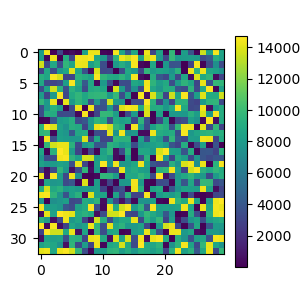

In [278]:
c = (3,0)
m = (0,0)
plt.figure(figsize=(3,3))
plt.imshow(cm_dic[c,m,'shuffle_mat'][:,:30])
plt.colorbar()

In [170]:
cm_dic[c,m,'shuffle_mat'][:,0]

array([14432.,  3767.,  8214.,  3435.,   466.,  3474.,  7850.,  8688.,
        8257.,  7970., 14697.,  9384.,  8294.,  8493.,   116., 14354.,
       14585.,   281.,  8784.,  3021.,  3873.,  3828., 14587.,  3335.,
        8694.,  9778., 13632., 14443.,  8858.,  9145.,  3872.,  7810.,
        9088.])

In [156]:
cm_dic[c,m,'shuffle_mat'][:,1]

array([ 3976.,   228.,  7886.,   126.,  9726.,  9088., 14343.,   468.,
        7441.,  7887.,  3004.,  8985., 13670.,  7929.,  8636.,  8294.,
        3970.,  3435., 14443., 14482.,  9560.,   659.,  9776.,  3918.,
        8215.,   268.,   273., 13735.,  7601.,  9479.,  3477.,  9725.,
        3824.])

In [171]:
m = (0,1.1)
np.where(cm_dic[c,m,'sel'])[0]

array([2952, 2957, 2958, 2963, 2998, 2999, 3000, 3003, 3006, 3013, 3045,
       3047, 3086, 3095, 3099, 3135, 3186, 3187, 3188, 3189, 3193, 3233,
       3234, 3237, 3249, 3279, 3280, 3286, 3288, 3327, 3331, 3333, 3339,
       3373, 3378, 3379, 3381, 3383, 3393, 3429, 3433, 3472, 3490, 3514,
       3517, 3520, 3522, 8282, 8287, 8289, 8291, 8293, 8328, 8333, 8334,
       8337, 8340, 8346, 8382, 8384, 8387, 8388, 8392, 8429, 8431, 8437,
       8453, 8480, 8481, 8484, 8488, 8490, 8491, 8533, 8546, 8574, 8577,
       8580, 8582, 8590, 8626, 8633, 8637, 8639, 8678, 8683, 8689, 8727,
       8738, 8778, 8779, 8782, 8811, 8833, 8835, 8840, 8841, 8861, 8890,
       8891, 8901, 8937, 8939, 8941, 8945, 8946, 8948, 8950, 8957, 8983,
       8984, 8990, 8993], dtype=int64)

In [172]:
np.where(cm_dic[c,'sel'])[0]

array([   18,    24,    36,    72,    77,    78,   112,   113,   120,
         131,   157,   161,   187,   190,   194,   195,   234,   245,
         282,  2639,  2644,  2680,  2681,  2683,  2687,  2688,  2698,
        2727,  2733,  2734,  2766,  2769,  2771,  2773,  2776,  2777,
        2801,  2802,  2804,  2807,  2840,  2847,  2848,  2849,  2873,
        2877,  2880,  2881,  2882,  2884,  2911,  2917,  2918,  2920,
        2921,  2924,  2929,  2931,  2952,  2957,  2958,  2963,  2998,
        2999,  3000,  3003,  3006,  3013,  3045,  3047,  3086,  3095,
        3099,  3135,  3186,  3187,  3188,  3189,  3193,  3233,  3234,
        3237,  3249,  3279,  3280,  3286,  3288,  3327,  3331,  3333,
        3339,  3373,  3378,  3379,  3381,  3383,  3393,  3429,  3433,
        3472,  3490,  3514,  3517,  3520,  3522,  3571,  3572,  3573,
        3625,  3626,  3679,  3680,  3717,  3720,  3783,  3829,  3865,
        3875,  3919,  4024,  4026,  4132,  4133,  4152,  7257,  7259,
        7260,  7290,

### Implement the analysis of comparing command-locked command trajectories

In [ ]:
#TODO: this analysis also needs to match each command ? 

In [279]:
#Movement and Movement-Pool PSTH:

win = np.array([-5,5])
time = range(win[0],win[1]+1)
num_win = win[1]-win[0]+1
num_var = len(list(df.columns))
psth_var = ['u_vx', 'u_vy', 'kin_px', 'kin_py', 'u_v_mag', 'u_v_angle_ctr_bin']
num_psth_var = len(psth_var)

t_start = timeit.default_timer()
for bm in range(num_mag_bins_analyze):
    for ba in range(num_angle_bins):
        c = (bm,ba)
        c_idxs = np.where(cm_dic[c,'sel'])[0]
        da,psth,psth_sem=bmi_b.df_idx_win2psth_mat(df, c_idxs, win, psth_var)
        #ASSIGN:
        cm_dic[c,'mat'] = da
        cm_dic[c,'psth'] = psth
        cm_dic[c,'psth_sem'] = psth_sem
        
        #Calculate psth for individual movements: 
        for m in cm_dic[c]:
            #-----------------------------------------------------------------------------------
            #Calculate for true data:
            c_idxs = np.where(cm_dic[c,m,'sel'])[0]
            #ASSIGN:
            cm_dic[c,m,'mat'] = da.loc[:,:,c_idxs]
            mean,var,sem = bmi_util.da_mean_var_sem(da.loc[psth_var,:,c_idxs],axis=2)
            cm_dic[c,m,'psth'] = mean
            cm_dic[c,m,'psth_sem'] = sem
        
            #-----------------------------------------------------------------------------------
            #Calculate for shuffle:
            nan_mat = np.ones((num_psth_var, num_win, num_shuffle))*np.nan
            s_mean = xr.DataArray(nan_mat, 
                              coords={'var':psth_var,'time':time,'shuffle':range(num_shuffle)},
                              dims=['var','time','shuffle'])
            nan_mat = np.ones((num_psth_var, num_win, num_shuffle))*np.nan
            s_sem = xr.DataArray(nan_mat, 
                              coords={'var':psth_var,'time':time,'shuffle':range(num_shuffle)},
                              dims=['var','time','shuffle'])
            for s in range(num_shuffle):
                c_idxs = cm_dic[c,m,'shuffle_mat'][:,s]
                mean,var,sem = bmi_util.da_mean_var_sem(da.loc[psth_var,:,c_idxs],axis=2)
                s_mean.loc[psth_var,:,s] = mean
                s_sem.loc[psth_var,:,s] = sem
            #ASSIGN:
            cm_dic[c,m,'psth_shuffle'] = s_mean
            cm_dic[c,m,'psth_sem_shuffle'] = s_sem
            
t_elapsed = timeit.default_timer()-t_start
print(t_elapsed)

1533.9891481


In [283]:
1533/60.0

25.55

In [51]:
idx

NameError: name 'idx' is not defined

In [64]:
idx = df[cm_dic[(3,0),'sel']].index.values
var = ['u_vx', 'u_vy']
test_da = bmi_b.df_idx2da(df,idx,var)

In [65]:
test_da

<xarray.DataArray (var: 2, trial: 357)>
array([[-1.836056, -1.497971, -1.953945, ..., -1.939042, -2.505715, -1.764542],
       [-1.393913, -1.487384, -0.940038, ..., -0.971192, -1.467978, -2.068766]])
Coordinates:
  * var      (var) |S4 'u_vx' 'u_vy'
  * trial    (trial) int64 15 17 20 30 31 73 ... 14619 14666 14697 14698 14707

In [67]:
df.loc[idx[0],var]

u_vx   -1.836056
u_vy   -1.393913
Name: 15, dtype: float64

In [60]:
df[cm_dic[(3,0),'sel']].index.values

array([   15,    17,    20,    30,    31,    73,    75,    76,    79,
         115,   116,   117,   121,   122,   126,   128,   154,   155,
         159,   185,   186,   203,   226,   228,   230,   232,   236,
         268,   269,   273,   276,   278,   281,   309,   311,   316,
         319,   438,   440,   466,   468,   491,   538,   539,   543,
         590,   621,   659,   694,  2953,  2955,  2974,  3004,  3005,
        3009,  3017,  3021,  3048,  3052,  3053,  3085,  3092,  3093,
        3096,  3100,  3137,  3141,  3146,  3160,  3185,  3194,  3232,
        3241,  3251,  3289,  3290,  3297,  3328,  3329,  3335,  3336,
        3337,  3341,  3342,  3385,  3430,  3435,  3437,  3438,  3439,
        3448,  3474,  3477,  3478,  3479,  3492,  3515,  3521,  3524,
        3544,  3574,  3671,  3716,  3719,  3765,  3766,  3767,  3788,
        3824,  3828,  3872,  3873,  3918,  3968,  3970,  3973,  3976,
        4025,  4028,  4079,  4135,  7327,  7441,  7478,  7480,  7520,
        7555,  7601,

In [ ]:
idx = cm[(0,0),'sel']
cm_dic[]  bmi_b.df_idx2mat(df, idx, var)

In [48]:
cm_dic[(1,0),(0,1.1),'mat']

<xarray.DataArray (var: 86, time: 11, trial: 37)>
array([[[ 1.      ,  1.      , ...,  0.      ,  0.      ],
        [ 2.      ,  1.      , ...,  3.      ,  1.      ],
        ...,
        [ 0.      ,  5.      , ...,  0.      ,  1.      ],
        [ 2.      ,  0.      , ...,  0.      ,  0.      ]],

       [[ 2.      ,  0.      , ...,  1.      ,  0.      ],
        [ 0.      ,  0.      , ...,  1.      ,  0.      ],
        ...,
        [ 1.      ,  0.      , ...,  0.      ,  0.      ],
        [ 1.      ,  0.      , ...,  1.      ,  0.      ]],

       ...,

       [[-2.637407, -2.151023, ..., -3.246296, -2.678206],
        [-1.974783, -1.337726, ..., -2.749987, -2.532898],
        ...,
        [-0.767043, -1.918899, ..., -2.606181, -1.230382],
        [-1.782464, -3.129351, ..., -1.819319, -2.190538]],

       [[-2.637407, -2.151023, ...,  3.036889, -2.678206],
        [-1.974783, -1.337726, ...,  3.533198, -2.532898],
        ...,
        [-0.767043, -1.918899, ..., -2.606181, -1.230

In [45]:
cm_dic[(1,0),(0,1.1),'mat'].trial

<xarray.DataArray 'trial' (trial: 37)>
array([2964, 2971, 3007, 3010, 3113, 3156, 3200, 3203, 3332, 3344, 3346, 3348,
       3377, 3397, 3475, 3531, 8355, 8386, 8443, 8496, 8531, 8593, 8603, 8631,
       8642, 8652, 8679, 8692, 8698, 8745, 8842, 8844, 8845, 8852, 8857, 8898,
       8960], dtype=int64)
Coordinates:
  * trial    (trial) int64 2964 2971 3007 3010 3113 ... 8845 8852 8857 8898 8960

In [47]:
cm_dic[(1,0),(0,1.1),'mat'].trial[1]

<xarray.DataArray 'trial' ()>
array(2971, dtype=int64)
Coordinates:
    trial    int64 2971

In [50]:
cm_dic[(1,0),(0,1.1),'mat'].mean(dim='trial')

<xarray.DataArray (var: 86, time: 11)>
array([[ 1.081081,  1.054054,  1.135135, ...,  1.162162,  0.972973,  0.945946],
       [ 0.405405,  0.378378,  0.648649, ...,  0.486486,  0.540541,  0.567568],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.027027,  0.      ],
       ...,
       [-2.767615, -2.741249, -2.506399, ..., -2.073776, -2.117944, -1.870025],
       [-2.767615, -2.741249, -2.506399, ..., -2.073776, -2.117944, -1.870025],
       [-0.050562, -0.024196, -0.468609, ..., -0.715249, -0.929233, -0.851131]])
Coordinates:
  * var      (var) |S23 'n_0' 'n_1' ... 'u_v_angle_ctr_t' 'u_v_angle_ctr_bin'
  * time     (time) int32 -5 -4 -3 -2 -1 0 1 2 3 4 5

### Calculate the differences between the psth's

In [280]:
#cm_dic
#add [c,m,'psth_diff'], [c,m,psth_shuffle_diff]

lags_analyze = []


psth_analyze_var = ['u_vx', 'u_vy']
for bm in range(num_mag_bins_analyze):
    for ba in range(num_angle_bins):
        c = (bm,ba)
        psth_mpool = cm_dic[c,'psth'].loc[psth_analyze_var,:]
        for m in cm_dic[c]:
            psth_m = cm_dic[c,m,'psth'].loc[psth_analyze_var,:]
            cm_dic[c,m,'psth_diff'] = np.linalg.norm(psth_mpool-psth_m, ord='fro')
            
            #SHUFFLE:
            psth_ms = cm_dic[c,m,'psth_shuffle'].loc[psth_analyze_var,:]
            psth_mpool_rep = np.array(psth_mpool)[...,None]
            shuffle_diff = psth_mpool_rep-psth_ms
            cm_dic[c,m,'psth_shuffle_diff'] = np.linalg.norm(shuffle_diff, axis=(0,1), ord='fro')
            
#         #DEBUG: slow implementation to verify my broadcasting above worked
#         shuffle_psth = cm_dic[c,m,'psth_shuffle'].loc[psth_analyze_var,:]
#         shuffle_diff = np.ones(num_shuffle)*np.nan
#         for s in range(num_shuffle):
#             shuffle_diff[s] = np.linalg.norm(psth_mpool-shuffle_psth[:,:,s])
#         cm_dic[c,m,'psth_shuffle_diff'] = shuffle_diff
        

### Stats

In [284]:
cm_dic[c,m,'psth_shuffle_diff'].shape

(1000L,)

<IPython.core.display.Javascript object>


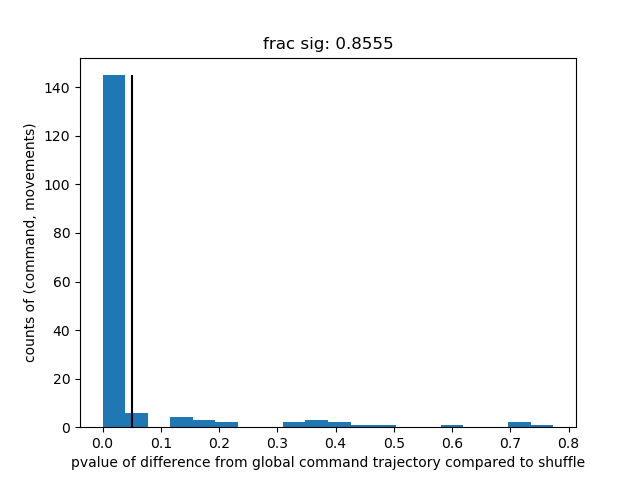

Text(0,0.5,'counts of (command, movements)')

In [285]:
#Count how many shuffle diffs are greater than true diff, and divide by number of shuffles for pval
#TODO: Make a data frame for each (c,m) to store the results
cm_dic['p'] = []
for bm in range(num_mag_bins_analyze):
    for ba in range(num_angle_bins):
        c = (bm,ba)
        for m in cm_dic[c]:
            num = np.sum(cm_dic[c,m,'psth_shuffle_diff']-cm_dic[c,m,'psth_diff']>0)
            p = float(num)/num_shuffle
            cm_dic[c,m,'p'] = p
            cm_dic['p'].append(p)
            
p_sig =0.05
frac_sig = float(np.sum(np.array(cm_dic['p'])<=p_sig))/len(cm_dic['p'])

plt.figure()
n,bins,patch=plt.hist(cm_dic['p'],20)
plt.vlines(0.05, 0, n.max() )
plt.title('frac sig: ' + str(round(frac_sig,4)))
plt.xlabel('pvalue of difference from global command trajectory compared to shuffle')
plt.ylabel('counts of (command, movements)')



In [287]:
save_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\command_temporal_order'
save_path = os.path.join(save_dir, 'behavior_analysis_shuffle1000.pkl')

with open(save_path, 'wb') as f: 
    data = pickle.dump(cm_dic, f, protocol=pickle.HIGHEST_PROTOCOL)


In [40]:
# Test load the results
save_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\command_temporal_order'
save_path = os.path.join(save_dir, 'behavior_analysis_shuffle1000.pkl')
with open(save_path, 'rb') as f: 
    test = pickle.load(f)
np.sum(np.array(test['p'])<=0.05)/float(len(test['p']))    

0.8554913294797688

In [41]:
#if you want to use the loaded results: 
use_loaded_results = True
if use_loaded_results:
    cm_dic = test

### Visualize the diff with PSTH (movement, movement_pool, movement_shuffle

1.5119826745210663
[0.60348769 0.55081372 0.50749252 0.55031683 0.64095547 0.7905639
 0.61268172 0.66964039 0.56917084 0.7235924  0.56231956 0.71376299
 0.63394882 0.81074115 0.51669916 0.70388781 0.47436144 0.64448227
 0.4979241  0.63647786 0.45831338 0.66322581 0.6068495  0.62133574
 0.63290475 0.42683178 0.59103026 0.49296271 0.90846375 0.62873149
 0.48248128 0.50182706 0.5432057  0.63497102 0.65752357 1.1085731
 0.67658524 0.43850543 0.75020628 0.62546184 0.74354868 0.58116832
 0.61563085 0.90457533 0.6776101  0.88487298 0.65308688 0.91403826
 0.62977059 0.73375647 0.58136063 0.59541146 0.53090304 0.92816849
 1.17504082 0.89659909 0.8136813  0.53703082 0.65783828 0.50137126
 0.55436971 0.68913004 0.62587068 0.47554901 0.84963167 0.61504556
 0.65281129 0.87822992 0.80170109 0.58289858 0.64972746 0.61101503
 0.79190799 0.56140384 0.79986312 0.74862931 0.86174101 0.61612029
 0.75278215 0.34909104 0.59583818 0.62423509 0.54299458 0.54769669
 1.64123773 0.52308301 0.99278776 0.5869119  

<IPython.core.display.Javascript object>


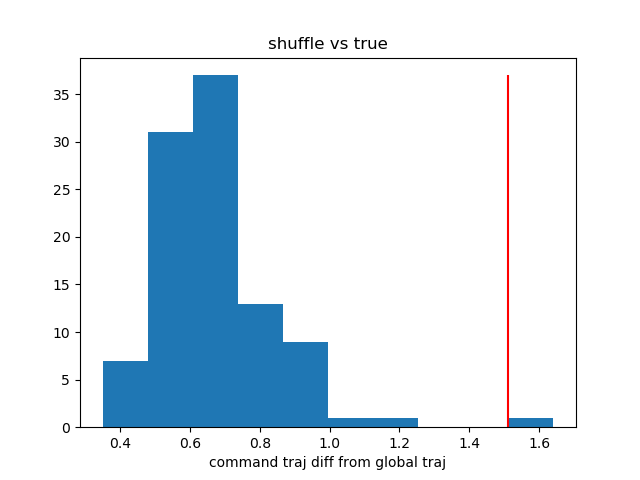

<IPython.core.display.Javascript object>


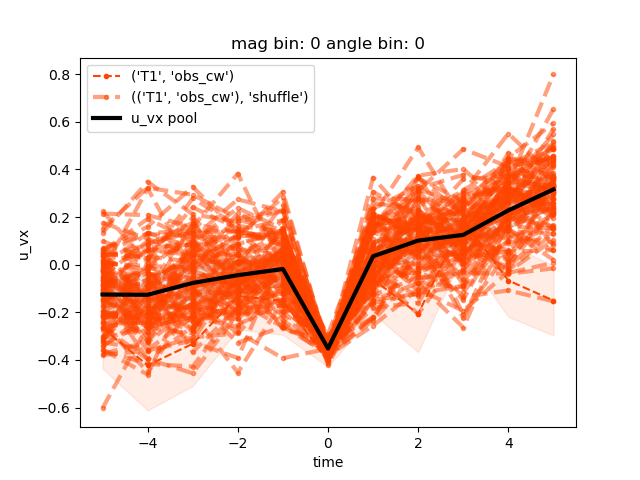

<IPython.core.display.Javascript object>


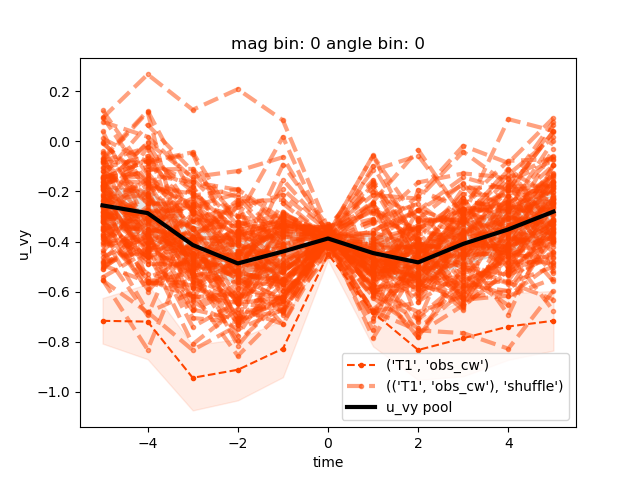

In [255]:
#VISUALIZE THE DIFF FROM GLOBAL TRAJ
c=(0,0)
m=cm_dic[c][1]
m_list = [m]


true = cm_dic[c,m,'psth_diff'] 
shuffle = cm_dic[c,m,'psth_shuffle_diff']
print(true)
print(shuffle)

plt.figure()
n,bins,patches=plt.hist(shuffle)
plt.vlines(true,0,n.max(),color='r')
plt.xlabel('command traj diff from global traj')
plt.title('shuffle vs true')

#Visualize PSTH (pool, movement, movement_shuffle):


x = np.arange(win[0], win[1]+1)

fill_alpha=0.1

task_rot_label_dic = {0:'co', 1.1:'obs_cw', 1.2:'obs_ccw'}

#INDIVIDUAL MOVEMENT
plot_var = ['u_vx', 'u_vy']
for v in plot_var:
    plt.figure()
    for m in m_list:
        m_pretty = ('T'+str(m[0]),task_rot_label_dic[m[1]])
        y = cm_dic[c,m,'psth'].loc[v,:]
        y_sem = cm_dic[c,m,'psth_sem'].loc[v,:]
        
        if m[1] == 0:
            plt.plot(x, y, label=m_pretty, color=target_color[m[0]])
        else:
            plt.plot(x, y, '.--', label=m_pretty, color=target_color[m[0]])    
        plt.fill_between(x, y-y_sem, y+y_sem,alpha=fill_alpha,color=target_color[m[0]])
        
        
        for s in range(num_shuffle):
            y_s = cm_dic[c,m,'psth_shuffle'].loc[v,:,s]
            y_s_sem = cm_dic[c,m,'psth_sem_shuffle'].loc[v,:,s]
            if s==num_shuffle-1:
                if m[1] == 0:
                    plt.plot(x, y_s, label=(m_pretty, 'shuffle'), color=target_color[m[0]], linewidth=3, alpha=0.5)
                else:
                    plt.plot(x, y_s, '.--', label=(m_pretty, 'shuffle'), color=target_color[m[0]], linewidth=3,alpha=0.5)    
            else:
                if m[1] == 0:
                    plt.plot(x, y_s, color=target_color[m[0]], linewidth=3, alpha=0.5)
                else:
                    plt.plot(x, y_s, '.--', color=target_color[m[0]], linewidth=3,alpha=0.5)
        
    #MOVE_POOL:    
    y = cm_dic[c,'psth'].loc[v,:]
    y_sem = cm_dic[c,'psth_sem'].loc[v,:]
    plt.plot(x, y, color='k', label=v+' pool', linewidth=3)
    plt.fill_between(x, y-y_sem, y+y_sem,alpha=fill_alpha, color='k')

    plt.title('mag bin: ' + str(c[0]) + ' angle bin: ' + str(c[1]))
    plt.ylabel(v)
    plt.xlabel('time')
    plt.legend()

<IPython.core.display.Javascript object>


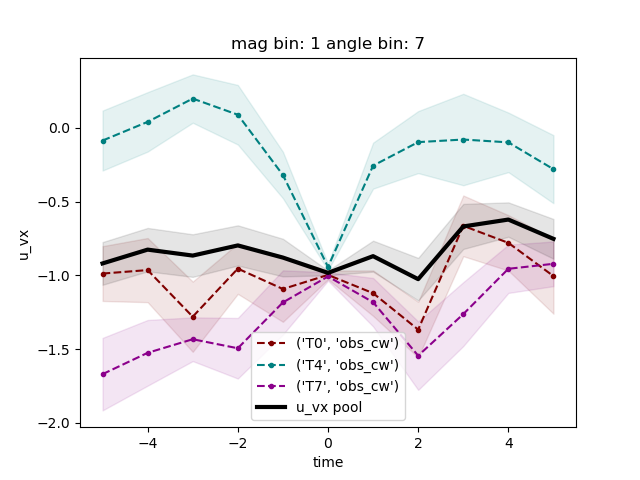

<IPython.core.display.Javascript object>


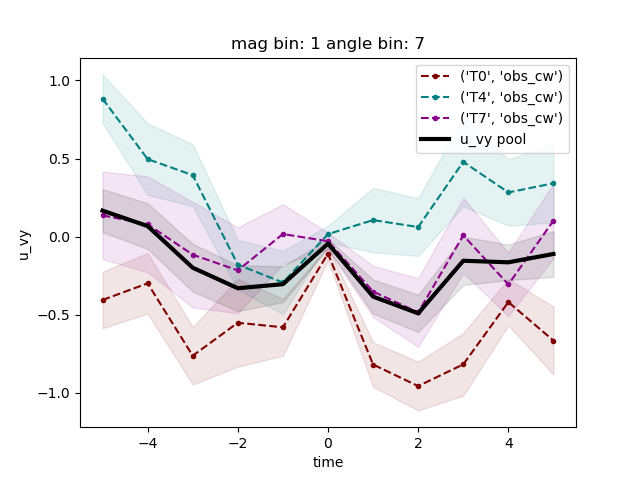

In [180]:
#Visualize PSTH:

c=(1,7)
x = np.arange(win[0], win[1]+1)

fill_alpha=0.1

task_rot_label_dic = {0:'co', 1.1:'obs_cw', 1.2:'obs_ccw'}

#INDIVIDUAL MOVEMENT
plot_var = ['u_vx', 'u_vy']
for v in plot_var:
    plt.figure()
    for m in cm_dic[c]:
        m_pretty = ('T'+str(m[0]),task_rot_label_dic[m[1]])
        y = cm_dic[c,m,'psth'].loc[v,:]
        y_sem = cm_dic[c,m,'psth_sem'].loc[v,:]
        if m[1] == 0:
            plt.plot(x, y, label=m_pretty, color=target_color[m[0]])
        else:
            plt.plot(x, y, '.--', label=m_pretty, color=target_color[m[0]])    
        plt.fill_between(x, y-y_sem, y+y_sem,alpha=fill_alpha,color=target_color[m[0]])
        
    #MOVE_POOL:    
    y = cm_dic[c,'psth'].loc[v,:]
    y_sem = cm_dic[c,'psth_sem'].loc[v,:]
    plt.plot(x, y, color='k', label=v+' pool', linewidth=3)
    plt.fill_between(x, y-y_sem, y+y_sem,alpha=fill_alpha, color='k')

    plt.title('mag bin: ' + str(c[0]) + ' angle bin: ' + str(c[1]))
    plt.ylabel(v)
    plt.xlabel('time')
    plt.legend()